In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from jax.example_libraries.optimizers import adam as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 2 ** 12
NN_SHAPES = jnp.array([64, 64, 64])
SCALE = 0.1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 10)

BETA = 0.9
MAX_AGE = 2.
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(x), x]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log(x / (1 + BETA)) + BETA * jnp.log((BETA * x) / (1 + BETA)), (x / (1 + BETA))]), 
                                                          jnp.array([(1 + BETA + BETA**2) * jnp.log(x) - (1 + BETA + BETA **2) * jnp.log(1 + BETA + BETA**2) + BETA * (1 + 2 * BETA) * jnp.log(BETA),
                                                                     x / (1 + BETA + BETA**2)])))

In [3]:
initializer = jax.nn.initializers.glorot_normal()
w0 = SCALE * initializer(INIT_KEYS[0], (5, NN_SHAPES[0]), jnp.float32)
w1 = SCALE * initializer(INIT_KEYS[1], (NN_SHAPES[0], NN_SHAPES[1]), jnp.float32)
w2 = SCALE * initializer(INIT_KEYS[2], (NN_SHAPES[1], NN_SHAPES[2]), jnp.float32)
w3 = SCALE * initializer(INIT_KEYS[3], (NN_SHAPES[2] + 5, NN_SHAPES[3]), jnp.float32)
wf = SCALE * initializer(INIT_KEYS[4], (NN_SHAPES[3], 1), jnp.float32)
b0 = SCALE * initializer(INIT_KEYS[5], (1, NN_SHAPES[0]), jnp.float32)
b1 = SCALE * initializer(INIT_KEYS[6], (1, NN_SHAPES[1]), jnp.float32)
b2 = SCALE * initializer(INIT_KEYS[7], (1, NN_SHAPES[2]), jnp.float32)
b3 = SCALE * initializer(INIT_KEYS[8], (1, NN_SHAPES[3]), jnp.float32)
bf = SCALE * initializer(INIT_KEYS[9], (1, 1), jnp.float32)
params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': w3, 'cw3': w3, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

In [4]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000))), 4)
X = jnp.linspace(1e-5, 1., 1000)
T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334))), 4)

opt_init, opt_update, get_params = optimizer(step_size=1e-1)
init_opt_state = opt_init(params0)

In [5]:
def plot_predictions(opt_state):
    params = get_params(opt_state)
    init0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, jnp.array([1., 0., 0., 0.]))
    pred0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, jnp.array([1., 0., 0., 0.]))
    true0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))

    init1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, jnp.array([0., 1., 0., 0.]))
    pred1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, jnp.array([0., 1., 0., 0.]))
    true1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))

    init2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, jnp.array([0., 0., 1., 0.]))
    pred2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, jnp.array([0., 0., 1., 0.]))
    true2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

    df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                       init0, pred0, true0, 
                                       init1, pred1, true1,
                                       init2, pred2, true2), 
                                      axis=1)).set_index(0)
    df.columns = ['initial_v0', 'initial_c0', 'predicted_v0', 'predicted_c0', 'true_v0', 'true_c0',
                  'initial_v1', 'initial_c1', 'predicted_v1', 'predicted_c1', 'true_v1', 'true_c1',
                  'initial_v2', 'initial_c2', 'predicted_v2', 'predicted_c2', 'true_v2', 'true_c2']

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    df.plot(y=['predicted_v0', 'true_v0'], ax=axes.flatten()[0])
    df.plot(y=['predicted_v1', 'true_v1'], ax=axes.flatten()[1])
    df.plot(y=['predicted_v2', 'true_v2'], ax=axes.flatten()[2])
    df.plot(y=['predicted_c0', 'true_c0'], ax=axes.flatten()[3])
    df.plot(y=['predicted_c1', 'true_c1'], ax=axes.flatten()[4])
    df.plot(y=['predicted_c2', 'true_c2'], ax=axes.flatten()[5])
    
    return fig

In [6]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e3)


@jax.jit
def neural_network(params, x, t):
    l0 = jnp.concatenate((x[jnp.newaxis], t))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    # l3 = jnp.squeeze(relu(l2, params['w2'], params['b2']))
    
    vl3 = relu(jnp.concatenate((l0, l2)), params['vw3'], params['vb3'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.squeeze(jnp.select(jnp.where(t == 1, size=1)[0] > MAX_AGE, jnp.zeros(1), vu))
    
    cl3 = relu(jnp.concatenate((l0, l2)), params['cw3'], params['cb3'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.squeeze(jnp.select(jnp.where(t == 1, size=1)[0] >= MAX_AGE, x[jnp.newaxis], cu))
    
    return jnp.concatenate((v.reshape(-1), c.reshape(-1)))


@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.jit
def loss(params, x, t):
    v0, c0 = neural_network(params, x, t)
    v1, c1 = neural_network(params, x - c0, increment_t(t))
    x1 = x - c0
    
    c0x = jax.grad(lambda params, x, t: neural_network(params, x, t)[1], (1))(params, x, t)
    v0x = jax.grad(lambda params, x, t: neural_network(params, x, t)[0], (1))(params, x, t)
    v1x = jax.grad(lambda params, x, t: neural_network(params, x, t)[0], (1))(params, x1, increment_t(t))
    
    loss_euler = jax.lax.select((jnp.where(t == 1, size=1)[0][0] < MAX_AGE), (c1 - (BETA * c0)), 0.)
    loss_bellman = (jnp.log(c0) + BETA * v1) - v0
    loss_foc = 0 # jax.lax.select((jnp.where(t == 1, size=1)[0][0] < MAX_AGE), BETA * v1x * c0 - 1, 0.)
    loss_envelope = 0 # (c0x / v0x) - c0
    
    # return jnp.array([loss_euler, loss_bellman, loss_foc, loss_envelope])
    return jnp.array([loss_euler, loss_bellman])


@jax.tree_util.Partial(jax.jit, static_argnums=(3,))
def batch_loss(params, xs, ts, adaptive=True):
    losses = jax.vmap(loss, in_axes=(None, 0, 0))(params, xs, ts)
    if adaptive:
        weights = jnp.mean(losses**2, axis=0)
        W = jnp.diag(jax.nn.softmax(weights))
    else:
        W = jnp.diag(jnp.array([1., 1.])) # jnp.diag(jnp.ones(4)) / 4
    return jnp.mean(jax.vmap(lambda l: l @ W @ l.T)(losses)), W

In [7]:
def training_loop(X, T, opt_state, opt_update, get_params, adaptive=True, max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    
    best_opt_state = opt_state
    best_loss, _ = batch_loss(get_params(best_opt_state), all_X, all_T, adaptive=False)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (2, MB))
        params = get_params(opt_state)

        (val_loss, W), grad = jax.value_and_grad(batch_loss, has_aux=True)(get_params(opt_state), X[sample[0]], T[sample[1]], adaptive=adaptive)
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            print(loss_means)
            print(W)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j == 0:
            start_time = time.time()
        
        j += 1
        if j % 100 == 0:
            fair_loss, _ = batch_loss(params, all_X, all_T, adaptive=False)
            if fair_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            W_print = list(map(lambda x :f'{x:.2f}', jnp.diag(W)))
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.2e}\tFair Loss: {fair_loss:.2e}\tAverage samples/s: {((MB * j) / (time.time() - start_time)):.2f}\nCurrent Weights: {W_print}')
        
    return opt_state, best_opt_state

In [8]:
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, adaptive=True, max_iter=5000)

Iteration: 100	Current Loss: 2.19e-01	Fair Loss: 4.70e-01	Average samples/s: 32224.06
Current Weights: ['0.48', '0.52']
Iteration: 200	Current Loss: 7.61e-02	Fair Loss: 1.94e-01	Average samples/s: 31433.81
Current Weights: ['0.48', '0.52']
Iteration: 300	Current Loss: 7.51e-02	Fair Loss: 1.86e-01	Average samples/s: 31450.25
Current Weights: ['0.48', '0.52']
Iteration: 400	Current Loss: 4.98e-02	Fair Loss: 1.26e-01	Average samples/s: 31510.55
Current Weights: ['0.48', '0.52']
Iteration: 500	Current Loss: 4.47e-02	Fair Loss: 7.75e-02	Average samples/s: 31681.71
Current Weights: ['0.48', '0.52']
Iteration: 600	Current Loss: 4.87e-02	Fair Loss: 1.09e-01	Average samples/s: 31615.75
Current Weights: ['0.48', '0.52']
Iteration: 700	Current Loss: 1.65e-02	Fair Loss: 8.01e-02	Average samples/s: 31756.17
Current Weights: ['0.49', '0.51']
Iteration: 800	Current Loss: 3.56e-02	Fair Loss: 6.83e-02	Average samples/s: 31774.87
Current Weights: ['0.48', '0.52']
Iteration: 900	Current Loss: 3.91e-02	Fa

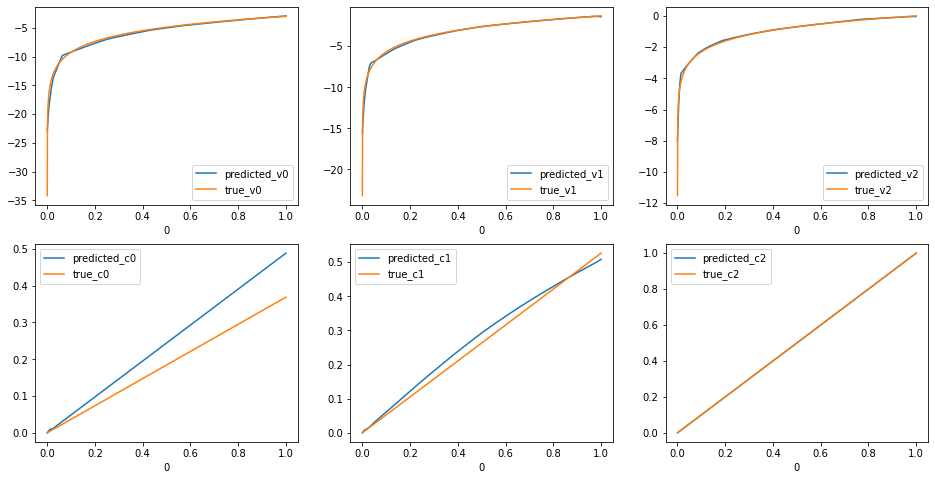

In [9]:
fig = plot_predictions(best_opt_state)

In [10]:
current_opt_state, best_opt_state = training_loop(X, T, init_opt_state, opt_update, get_params, adaptive=False, max_iter=5000)

Iteration: 100	Current Loss: 1.87e-01	Fair Loss: 2.24e-01	Average samples/s: 67807.21
Current Weights: ['1.00', '1.00']
Iteration: 200	Current Loss: 1.36e-01	Fair Loss: 1.78e-01	Average samples/s: 69401.10
Current Weights: ['1.00', '1.00']
Iteration: 300	Current Loss: 1.01e-01	Fair Loss: 1.45e-01	Average samples/s: 69792.05
Current Weights: ['1.00', '1.00']
Iteration: 400	Current Loss: 8.58e-02	Fair Loss: 1.13e-01	Average samples/s: 69509.83
Current Weights: ['1.00', '1.00']
Iteration: 500	Current Loss: 9.20e-02	Fair Loss: 8.48e-02	Average samples/s: 69346.92
Current Weights: ['1.00', '1.00']
Iteration: 600	Current Loss: 9.95e-02	Fair Loss: 1.10e-01	Average samples/s: 69049.52
Current Weights: ['1.00', '1.00']
Iteration: 700	Current Loss: 1.70e-02	Fair Loss: 5.54e-02	Average samples/s: 69129.39
Current Weights: ['1.00', '1.00']
Iteration: 800	Current Loss: 6.18e-02	Fair Loss: 5.88e-02	Average samples/s: 68914.44
Current Weights: ['1.00', '1.00']
Iteration: 900	Current Loss: 5.60e-02	Fa

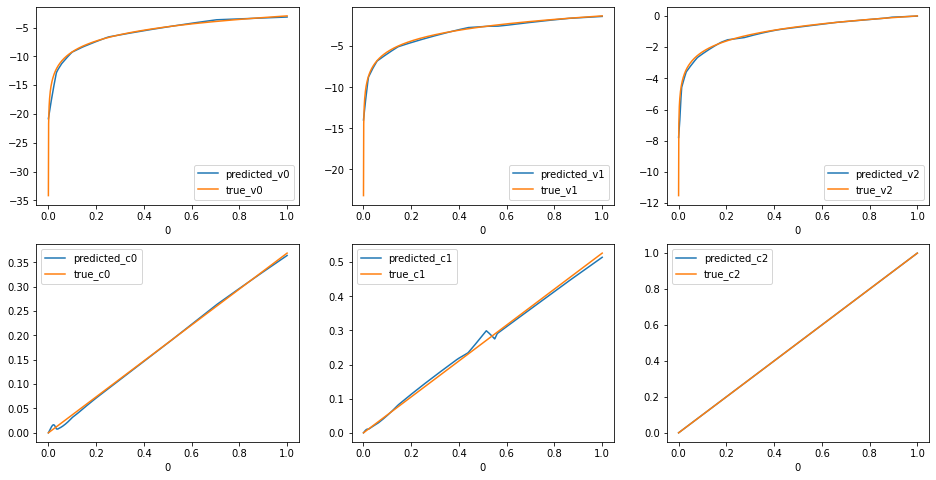

In [11]:
fig = plot_predictions(best_opt_state)